In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/JHU_CSSE-DECOM'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

73

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
262,2020-10-25,1 wk ahead inc case,2020-10-31,42,point,NaN,12053.0
313,2020-10-25,2 wk ahead inc case,2020-11-07,42,point,NaN,13233.0
364,2020-10-25,3 wk ahead inc case,2020-11-14,42,point,NaN,14182.0
415,2020-10-25,4 wk ahead inc case,2020-11-21,42,point,NaN,15612.0
227,2020-11-01,1 wk ahead inc case,2020-11-07,42,point,NaN,15903.0


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,target,target_end_date,location,type,quantile,value
262,2020-10-25,1 wk ahead inc case,2020-10-31,42,point,NaN,12053.0
313,2020-10-25,2 wk ahead inc case,2020-11-07,42,point,NaN,13233.0
227,2020-11-01,1 wk ahead inc case,2020-11-07,42,point,NaN,15903.0
364,2020-10-25,3 wk ahead inc case,2020-11-14,42,point,NaN,14182.0
275,2020-11-01,2 wk ahead inc case,2020-11-14,42,point,NaN,17833.0
...,...,...,...,...,...,...,...
1762,2022-02-27,3 wk ahead inc case,2022-03-19,42,point,NaN,5434.0
1601,2022-03-06,2 wk ahead inc case,2022-03-19,42,point,NaN,3188.0
1602,2022-03-06,3 wk ahead inc case,2022-03-26,42,point,NaN,2206.0
1763,2022-02-27,4 wk ahead inc case,2022-03-26,42,point,NaN,3932.0


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(66, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [36]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2021-12-01')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-10-31,2020-10-25,1 wk ahead inc case,42,point,NaN,12053.0,1721.857143
1,2020-11-07,2020-11-01,1 wk ahead inc case,42,point,NaN,15903.0,2271.857143
2,2020-11-14,2020-11-08,1 wk ahead inc case,42,point,NaN,21508.0,3072.571429
3,2020-11-21,2020-11-15,1 wk ahead inc case,42,point,NaN,38796.0,5542.285714
4,2020-11-28,2020-11-22,1 wk ahead inc case,42,point,NaN,53230.0,7604.285714


In [37]:
df_weekly.tail(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
47,2021-10-30,2021-10-24,1 wk ahead inc case,42,point,NaN,26016.0,3716.571429
48,2021-11-06,2021-10-31,1 wk ahead inc case,42,point,NaN,24734.0,3533.428571
49,2021-11-13,2021-11-07,1 wk ahead inc case,42,point,NaN,27606.0,3943.714286
50,2021-11-20,2021-11-14,1 wk ahead inc case,42,point,NaN,34828.0,4975.428571
51,2021-11-27,2021-11-21,1 wk ahead inc case,42,point,NaN,45481.0,6497.285714


In [31]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[1721.857142857143, 1721.857142857143, 1721.857142857143, 1721.857142857143, 1721.857142857143, 1721.857142857143, 1721.857142857143, 2271.8571428571427, 2271.8571428571427, 2271.8571428571427, 2271.8571428571427, 2271.8571428571427, 2271.8571428571427, 2271.8571428571427, 3072.5714285714284, 3072.5714285714284, 3072.5714285714284, 3072.5714285714284, 3072.5714285714284, 3072.5714285714284, 3072.5714285714284, 5542.285714285715, 5542.285714285715, 5542.285714285715, 5542.285714285715, 5542.285714285715, 5542.285714285715, 5542.285714285715, 7604.285714285715, 7604.285714285715, 7604.285714285715, 7604.285714285715, 7604.285714285715, 7604.285714285715, 7604.285714285715, 7482.714285714285, 7482.714285714285, 7482.714285714285, 7482.714285714285, 7482.714285714285, 7482.714285714285, 7482.714285714285, 7953.285714285715, 7953.285714285715, 7953.285714285715, 7953.285714285715, 7953.285714285715, 7953.285714285715, 7953.285714285715, 10669.857142857143, 10669.857142857143, 10669.85714285

In [38]:
len(predictions)

399

In [42]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-10-31') & (df1['Date'] <= '2021-12-03')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-10-31,4168,4555.9,431094,25603978,1171.7,1213.2,83007.2,2860489,-5275.682283,2774.207671
1,2020-11-01,3936,4641.3,435030,25603978,1242.5,1288.5,84249.5,2860489,-5275.682283,2774.207671
2,2020-11-02,5908,4809.2,440938,25603978,1546.0,1314.8,85795.4,2860489,-5275.682283,2774.207671
3,2020-11-03,5528,4948.0,446466,25603978,1591.3,1377.5,87386.6,2860489,-5275.682283,2774.207671
4,2020-11-04,5874,5100.1,452340,25603978,1720.1,1447.0,89107.6,2860489,-5275.682283,2774.207671


In [43]:
df1_copy.tail(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
394,2021-11-29,12574,11419.1,3477834,25603978,4359.1,3784.8,995228.6,2860489,-5275.682283,2774.207671
395,2021-11-30,14556,11488.9,3492390,25603978,5049.8,3785.6,1000278.8,2860489,-5275.682283,2774.207671
396,2021-12-01,18598,12154.4,3510988,25603978,6128.1,3968.4,1006406.6,2860489,-5275.682283,2774.207671
397,2021-12-02,21826,13648.1,3532814,25603978,6874.2,4440.6,1013280.8,2860489,-5275.682283,2774.207671
398,2021-12-03,17074,14725.1,3549888,25603978,5585.3,4783.9,1018866.1,2860489,-5275.682283,2774.207671


In [44]:
len(df1_copy)

399

In [45]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [47]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [48]:
merged_df_new.shape

(399, 12)

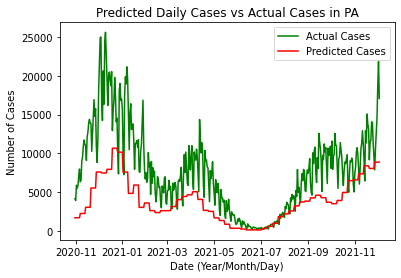

In [49]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [50]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

369
0.924812030075188
30
0.07518796992481203
399
[0.5868864820400328, 0.5625362950058072, 0.7085549859754328, 0.6885207773413272, 0.7068680383287125, 0.7595843140383771, 0.7846063118767647, 0.6422272215973004, 0.6535746961181544, 0.748019394093041, 0.7630520293223673, 0.7922588567248406, 0.806386812437605, 0.7966108197979281, 0.719758169593996, 0.6625031383379363, 0.7470718284020886, 0.7590518013981001, 0.7790788446526152, 0.7863896392817417, 0.7786969584722394, 0.5990823412698413, 0.46013191951239873, 0.5534016346264533, 0.6176679280983917, 0.6724804565485336, 0.6242518159806296, 0.6483321247280639, 0.3022310777862255, 0.1395920214657485, 0.3539264473843913, 0.5775866173599759, 0.6489573578485036, 0.6942877818490909, 0.6955606648136075, 0.5466670128611241, 0.4740113675162178, 0.6369729145296775, 0.541612699968495, 0.6939084395928051, 0.7075693963688335, 0.669928791984372, 0.5928907803907805, 0.508145595900698, 0.6014589239183347, 0.6113143527374786, 0.5912168115601504, 0.5749633543028

In [51]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.4131135179599672, 0.43746370499419285, 0.29144501402456724, 0.3114792226586728, 0.2931319616712875, 0.24041568596162288, 0.21539368812323534, 0.3577727784026996, 0.34642530388184556, 0.25198060590695903, 0.23694797067763274, 0.20774114327515936, 0.19361318756239498, 0.20338918020207186, 0.28024183040600403, 0.3374968616620637, 0.25292817159791137, 0.24094819860189987, 0.22092115534738477, 0.21361036071825834, 0.2213030415277606, 0.4009176587301587, 0.5398680804876013, 0.4465983653735467, 0.38233207190160834, 0.3275195434514664, 0.3757481840193704, 0.3516678752719361, 0.6977689222137745, 0.8604079785342515, 0.6460735526156087, 0.42241338264002415, 0.3510426421514964, 0.3057122181509091, 0.30443933518639255, 0.45333298713887593, 0.5259886324837821, 0.3630270854703225, 0.45838730003150496, 0.3060915604071949, 0.29243060363116646, 0.33007120801562795, 0.40710921960921953, 0.49185440409930203, 0.39854107608166534, 0.3886856472625214, 0.4087831884398496, 0.42503664569718436, 0.38747372670

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

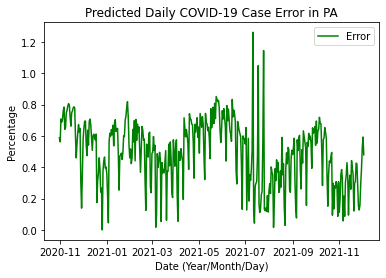

In [53]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

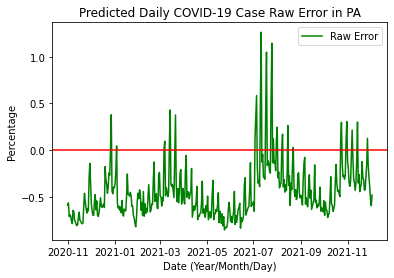

In [54]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

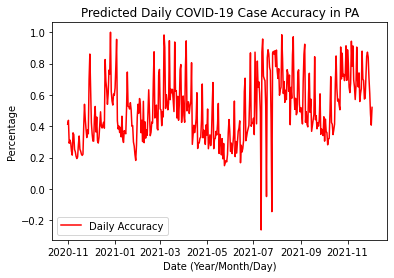

In [55]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [56]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [57]:
len(weeklyDateList)

58

In [58]:
del weeklyDateList[-1:]
len(averageWeeklyAccuracy)

57

In [59]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

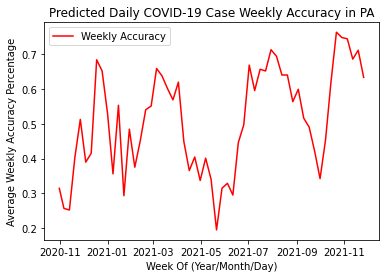

In [60]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [61]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [62]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

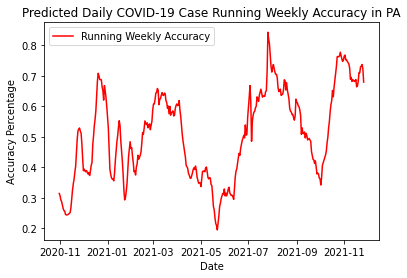

In [63]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

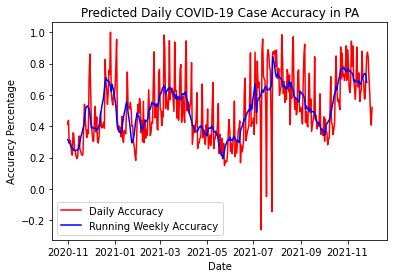

In [64]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [65]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [68]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [69]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

14

In [70]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

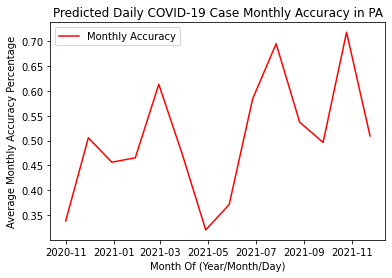

In [71]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [72]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [73]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

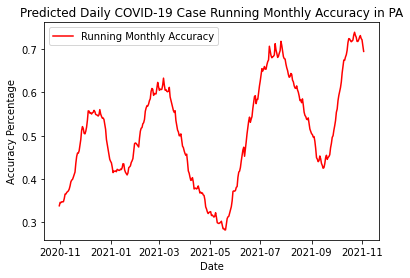

In [74]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [75]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [76]:
print(averageYearlyAccuracy)

[0.49166943555407455, 0.20468706622876662]


In [77]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

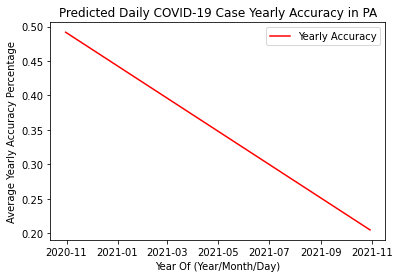

In [78]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [79]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [80]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

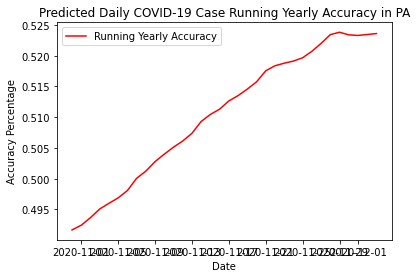

In [81]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [82]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.5092751011195187


In [84]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.4131135179599672, 0.43746370499419285, 0.29144501402456724, 0.3114792226586728, 0.2931319616712875, 0.24041568596162288, 0.21539368812323534, 0.3577727784026996, 0.34642530388184556, 0.25198060590695903, 0.23694797067763274, 0.20774114327515936, 0.19361318756239498, 0.20338918020207186, 0.28024183040600403, 0.3374968616620637, 0.25292817159791137, 0.24094819860189987, 0.22092115534738477, 0.21361036071825834, 0.2213030415277606, 0.4009176587301587, 0.5398680804876013, 0.4465983653735467, 0.38233207190160834, 0.3275195434514664, 0.3757481840193704, 0.3516678752719361, 0.6977689222137745, 0.8604079785342515, 0.6460735526156087, 0.42241338264002415, 0.3510426421514964, 0.3057122181509091, 0.30443933518639255, 0.45333298713887593, 0.5259886324837821, 0.3630270854703225, 0.45838730003150496, 0.3060915604071949, 0.29243060363116646, 0.33007120801562795, 0.40710921960921953, 0.49185440409930203, 0.39854107608166534, 0.3886856472625214, 0.4087831884398496, 0.42503664569718436, 0.38747372670

In [85]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.04258923171011372
0.20637158648930748


In [86]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.4827231905015602


In [87]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021

In [88]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [89]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[201]

In [90]:
#print(merged_inner)
standardVariantDF = merged_df_new[:201]
deltaVariantDF = merged_df_new[201:]

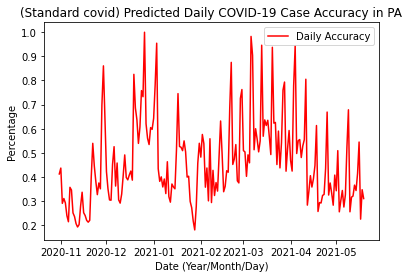

In [91]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

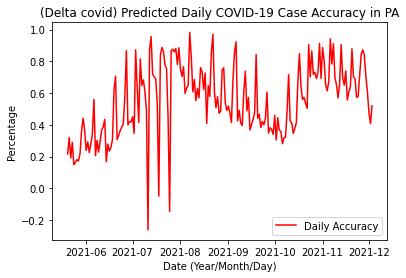

In [92]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()